In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import chess
import chess.engine
import gym
import math

class ChessEnv(gym.Env):
    def __init__(self):
        super(ChessEnv, self).__init__()
        self.board = chess.Board()

    def reset(self):
        self.board.reset()
        return self.get_state()

    def step(self, action):
        move = chess.Move.from_uci(action)
        if move in self.board.legal_moves:
            self.board.push(move)
        else:
            return self.get_state(), -1, True, {}

        reward = self.calculate_reward(move)
        done = self.board.is_game_over()
        return self.get_state(), reward, done, {}

    def get_board_state(self, board: chess.Board) -> dict[int, np.ndarray]:
        state_of_game = {}

        for piece_type in chess.PIECE_TYPES:
            board_state = np.zeros((8, 8), np.int8)
            for square, piece in board.piece_map().items():
                if piece.piece_type == piece_type:
                    j, i = self.calculate_index_for_square_int(square)
                    board_state[int(i)][int(j)] = 1 if piece.color else -1
            state_of_game[piece_type] = board_state

        return state_of_game

    def calculate_index_for_square_int_math(self, index: int):
        return math.modf(index / 8)
    
    
    def calculate_index_for_square_int(self, square):
        j = square % 8
        i = (square - j) // 8
        return j, i


    def get_state_for_move_action(self, move: chess.Move, board=None) -> torch.Tensor:
        # check if move is legal
        if board is not None:
            if move not in board.legal_moves:
                # if the move is not legal return none
                pass

        from_board = torch.zeros((8, 8), dtype=torch.float32)
        i, j = self.calculate_index_for_square_int(move.from_square)
        from_board[int(j)][int(i)] = 1

        to_board = torch.zeros((8, 8), dtype=torch.float32)
        i, j = self.calculate_index_for_square_int(move.to_square)
        to_board[int(j)][int(i)] = 1

        # return as 2x8x8 Tensor
        return torch.stack((to_board, from_board), dim=0)


    def get_state(self):
        board_state_dict = self.get_board_state(self.board)
        board_tensor = torch.tensor(list(board_state_dict.values()), dtype=torch.float32)
        return board_tensor

    def calculate_reward(self, move):
        reward = 0
        if self.board.is_capture(move):
            captured_piece = self.board.piece_at(move.to_square)
            reward += self.get_piece_value(captured_piece)
        return reward

    def get_piece_value(self, piece):
        if piece is None:
            return 0
        piece_values = {'P': 1, 'N': 3, 'B': 3, 'R': 5, 'Q': 9, 'K': 10}
        value = piece_values.get(piece.symbol(), 0)
        return value

class ChessNet(nn.Module):
    def __init__(self):
        super(ChessNet, self).__init__()
        self.conv1 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 64 * 8 * 8)
        x = self.fc1(x)
        return torch.sigmoid(x)


lr = 0.001
gamma = 0.9
epsilon = 0.1
batch_size = 64
target_update = 10


env = ChessEnv()
input_size = len(env.get_state())
output_size = 1

policy_net = ChessNet()
target_net = ChessNet()
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
criterion = nn.MSELoss()
list_of_losses = []

# Training
num_episodes = 10

for episode in range(num_episodes):
    print("Episode: ", episode)
    state = env.reset()
    done = False

    while not done:
        if np.random.rand() < epsilon:
            legal_moves_list = list(env.board.legal_moves)
            action = np.random.choice(legal_moves_list)
            action_array = env.get_state_for_move_action(action, env.board)
            concatenated_tensor = torch.cat((action_array, state), dim=0)
            # print(concatenated_tensor.shape)
        else:
            with torch.no_grad():
                action_idx = torch.argmax(q_value).item()
                action = list(env.board.legal_moves)[action_idx]
                action_array = env.get_state_for_move_action(action, env.board)
                concatenated_tensor = torch.cat((action_array, state), dim=0)
                # print(concatenated_tensor.shape)
                q_value = policy_net(concatenated_tensor.unsqueeze(0).float())

        next_state, reward, done, _ = env.step(action.uci())

        
        if not done:
            with torch.no_grad():
                target = torch.tensor(reward).float()
        else:
            target = torch.tensor(reward).float()

        q_value = policy_net(concatenated_tensor.unsqueeze(0).float())
        loss = criterion(q_value, target)
        list_of_losses.append(loss.item())
        print("q-value: ", q_value.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        state = next_state
        print("Next state ", state)

    
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())


Episode:  0
q-value:  0.5022534132003784
Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0., -1.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0., 

C:\Users\Besitzer\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


q-value:  0.9907179474830627
Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  0.,  1.,  1.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  0.,  0.,  0.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1., -1.,  0., -1., -1., -1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0., -1.,  0.,  0.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0

Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1., -1., -1., -1., -1., -1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 

Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1., -1.,  0., -1., -1., -1., -1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 

Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1., -1.,  0.,  0., -1., -1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 

q-value:  0.9999983310699463
Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1., -1.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
         [-1.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0

Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
         [-1., -1.,  0., -1., -1., -1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  1.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 

q-value:  0.9999998807907104
Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1., -1., -1., -1., -1., -1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0

q-value:  0.9999998807907104
Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0., -1., -1., -1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  1.,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0

q-value:  1.0
Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.],
         [ 0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1.,  0.,  0.,  0., -1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0., -1.,  0., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
 

Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1., -1., -1., -1., -1., -1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  1.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 

Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1., -1., -1., -1., -1., -1., -1., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 

q-value:  0.9999998807907104
Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1.,  0., -1., -1., -1., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0

Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
         [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1., -1., -1., -1., -1., -1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 

Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
         [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
         [-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  0., -1., -1., -1., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  1.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 

Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.],
         [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.],
         [-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  0., -1., -1., -1., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 

q-value:  0.9999998807907104
Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  1.,  0.,  0.,  1.,  1.],
         [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.],
         [-1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  0., -1., -1., -1., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0

Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  1.],
         [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
         [-1.,  0.,  0.,  0.,  1.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1., -1.,  0.,  0.,  0.,  0., -1.,  0.],
         [ 0.,  0., -1., -1., -1., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 

Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1., -1., -1., -1., -1., -1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0., -1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  1.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 

Next state  tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [-1., -1., -1., -1., -1., -1., -1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., -1.,  0.,  0.,  0.,  1.,  0.,  0.]],

        [[ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0., 

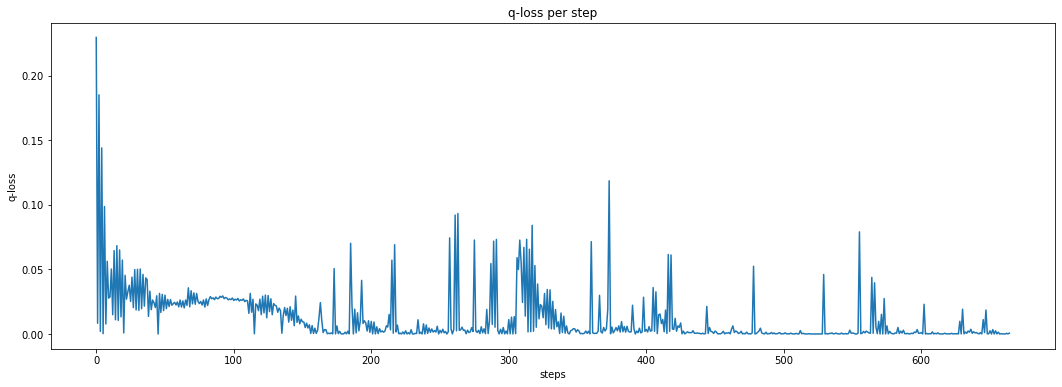

In [4]:
import matplotlib.pyplot as plt

def plot_numbers(numbers):
    fig, ax = plt.subplots(figsize=(18, 6)) 
    ax.plot(numbers)
    ax.set_xlabel('steps')
    ax.set_ylabel('q-loss')
    ax.set_title('q-loss per step')
    plt.show()
    
plot_numbers(list_of_losses)

In [4]:
torch.save(policy_net.state_dict(), 'model.pth')